# Shapely points, Pandas -> GeoPandas, Coordinate Reference Systems, CRS Transformations

This notebook will introduce us to the most basic shape, the point, and how it is implemented in python. We'll then make collections of points in the same coordinate system and show how we can make data structures that tell python "this collection of points all lives in the same space and uses the same coordinate system". In GIS software generally, the coordinate systems are typically called "Coordinate Reference Systems" (CRSs). We'll also demonstrate how the order of indices matters and how to check what each index refers to for a particular CRS. We'll see how you can both set the CRS and how to change to another CRS over the same space. We'll also demonstrate what we saw in class on Tuesday: that going back and forth between coordinate systems is safe because they are unique.

## Libraries

The first thing we need to do is import the relevant libraries. Libraries are collections of additional commands that are not universally used, and are often developed by third parties, so are not included in the python "base" library that you can use straight away. As an example, `type` is a base python command, and we can see the type of a base python data structure, like an integer.

In [1]:
type(7)

int

In contrast, the first library we'll use today is `shapely`, and in particular we'll use the `geometry` "module" of `shapely`. For now, it's not super important to know what a module is, just that it can be accessed by adding a "." after the library like `shapely.geometry`. We'll be using the `Point` "class" from `shapely.geometry`, and again it's not super important to know exactly what classes are or how they work. What is important, though, is if you try to make a `Point` without loading `shapely`, you'll get an error

In [2]:
Point(1,2)

NameError: name 'Point' is not defined

To fix this, we `import` the `shapely` library. And since `Point` lives in the `geometry` module, we can save a little typing by importing that module specifically and giving it a new, shorter, name. I like to call `shapely.geometry` "shg"

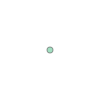

In [3]:
import shapely.geometry as shg

shg.Point(1,2)

Now we can see the point we made! Notice that because `Point` "lives in" `shapely.geometry` we have to put `shg.` before `Point`. We can also import `Point` directly if we're not planning on using the rest of `shapely.geometry`.

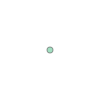

In [4]:
from shapely.geometry import Point

Point(1,2)

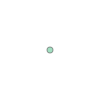

In [5]:
Point(5,7)

## Points in Shapely

I kind of just made a point out of nowhere, but you can find the documentation for `shapely.geometry.Point` [here](https://shapely.readthedocs.io/en/2.1.2/reference/shapely.Point.html). You can see that you can also pull it directly from `shapely` without going through `geometry`. We "instantiated" a `Point` using the second rule for "args": just 2 parameters that represent x and y.

We're going to need a couple other libraries today.

- `pandas`: This is the main python library for working with data frames. You can think of these kind of like excel sheets, where (typically) the top row gives the name of the columns and then all the rows after give the values for a particular unit. For example, you may have a data frame where the rows are restaurants in Madison and the columns include thinks like the average price of a meal, the time they open on Mondays, seating capacity, etc.
- `geopandas`: Geopandas extends `pandas` by allowing one of the columns to contain geographic information for the row and assigning a coordinate system to the whole "geo data frame" to allow it to understand where exactly on Earth the rows are.

Let's import those now

In [6]:
import pandas as pd # This is the standard shorthand for pandas
import geopandas as gpd # and for geopandas

## Pandas DataFrames

What exactly is a `pandas.DataFrame`? To get there, we need to first talk about two base python data structures: lists and dictionaries. A `list` is exactly what it sounds like: a list of elements! Lists are basically what we call "sets" in the class (note: base python also has a `set` data structure that is slightly different both from our definition of a "set" and from python `list`s), they can contain all different kinds of elements: integers, matrices, `Point`s, etc. In python, you can make a `list` by putting the elements between brackets separated by commas

In [7]:
my_list = [5,Point(1,2)] # You can name variables by setting the name before an = 
my_list # and then you can call those variables

[5, <POINT (1 2)>]

You can access a particular element of a list by putting its index in brackets after the name of the list

In [8]:
my_list[0]

5

A `dictionary` is slightly more complicated; it takes "keys" and maps them to "values." They're called "dictionaries" because you "look up" (or in computer science parlance, query) the key to get the "definition" that is the value. And similar to real dictionaries, the value is typically much more complicated than the key. We'll start with a simple example of a dictionary though. Dictionaries are defined with curly braces, with the structure `key:value, key:value,...`.

In [9]:
my_dictionary = {'key1':5,'key2':Point(1,2)}
my_dictionary

{'key1': 5, 'key2': <POINT (1 2)>}

You can query the dictionary similar to how you access elements of a list, but use the key instead of the index number.

In [10]:
my_dictionary['key1']

5

You can make a new entry to the dictionary by assigning a value to a key that doesn't exist yet

In [11]:
my_dictionary['new_key'] = 100
my_dictionary

{'key1': 5, 'key2': <POINT (1 2)>, 'new_key': 100}

One way to think of a `pandas.DataFrame` is as a list of dictionaries. Each row of the data frame is an element of the list, and the columns, or variables, are given by the keys of the dictionaries. If we call this list of dictionaries `df`, the value of a paricular variable, say "var", for the j-th row can be accessed as `df[j]['var']`. Here, `df['j']` gives us the j-th dictionary, and then adding `['var']` to the end queries the `'var'` key of that dictionary. Let's set up an example

In [12]:
df = [ # We're setting up a list of dictionaries called 
    {'id':5,'point':Point(1,2)}, # Here's the dictionary for the first observation, with 'id'=5 and 'point' at (1,2)
    {'id':9,'point':Point(3,1)} # and a second observation with 'id'=9 and 'point' at (3,1)
]
df

[{'id': 5, 'point': <POINT (1 2)>}, {'id': 9, 'point': <POINT (3 1)>}]

In [13]:
df[1]['id']

9

Pandas can actually use this exact data structure to make a `DataFrame`, which both prints much more nicely and has a bunch of other useful features. In this case, we'll simply use `pd.DataFrame` to make `df` into a `DataFrame`.

In [14]:
df = pd.DataFrame(df) # We are reassigning df. It will no longer be a list of dictionaries, but a pandas DataFrame
df

,id,point
0,5,POINT (1 2)
1,9,POINT (3 1)


There's lots of extra stuff you can do with pandas data frames. The documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) shows the many fancy "methods" you can use on them. It's useful to peruse this page and look at the examples of what all you can do with them. For now, we'll stick to just making them.

## GeoPandas GeoDataFrames

We have some spatial information associated with `df`, but pandas doesn't really "know" where each row "is". To pandas, "point" is just another column and doesn't mean anything in particular. Even if pandas somehow knew that the "point" column referred to where each row is in space, it doesn't know the coordinate system, so it wouldn't necessarily know how to place them in space.

Geopandas adds these two pieces of information to give pandas a more explicit representation of space. The easiest way to make a `geopandas.GeoDataFrame` is to give it a regular `pandas.DataFrame` and tell it which column is the "geometry" and what is the coordinate system. See the documentation [here](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoDataFrame.html).
 
We already have a column to call the geometry, "point", but what about the coordinate system? We need a "Coordinate Reference System" (CRS), a standard way to map coordinates to points on the Earth. The most commonly used CRS is ["WGS 84"](https://en.wikipedia.org/wiki/World_Geodetic_System). The vast majority of CRSs you will encounter have an [EPSG code](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset), which is a nice short string to refer to the CRS. For example WGS 84 is "EPSG:4326". Let's set that as the CRS.

In [15]:
gdf = gpd.GeoDataFrame(df, # we're making a GeoDataFrame called gdf from our DataFrame df
                      geometry='point', # the 'point' column contains the geometric information
                      crs = 'EPSG:4326') # and we're using WGS 84 as the coordinate system
gdf

,id,point
0,5,POINT (1 2)
1,9,POINT (3 1)


So far, it doesn't really look like there's anything different. However, you can see that `gdf` has a coordinate system

In [16]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

and more importantly, you can plot the whole GeoDataFrame!

<Axes: >

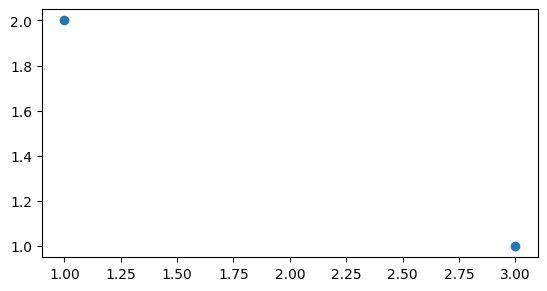

In [18]:
gdf.plot()

Not only that, you can add information stored in the other column to the plot

<Axes: >

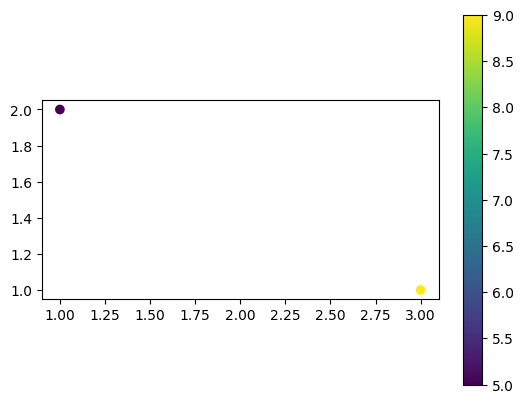

In [19]:
gdf.plot(column='id',legend=True)

Here's what happens if we use the `plot` method on `df` instead

<Axes: >

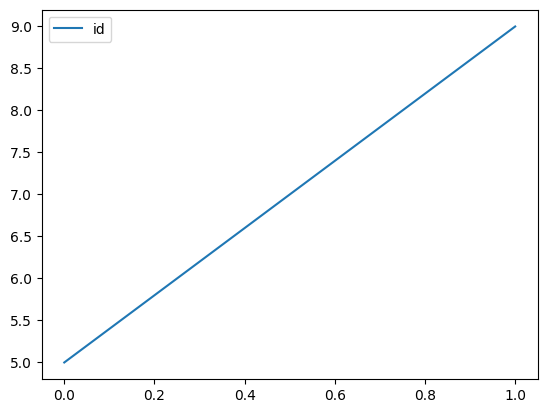

In [20]:
df.plot()

An ordinary `pandas.DataFrame` simply takes its index value to be its position along the x-axis and plots all numeric columns' values on the y-axis as line graphs (by default), which is what happened here.

You can see here why getting the correct index order is important. If we make a new GeoDataFrame with the index order swapped, we get a mirror-image plot. If you were interested in which observation is further north, for example, you'd get the answer wrong in this case!

<Axes: >

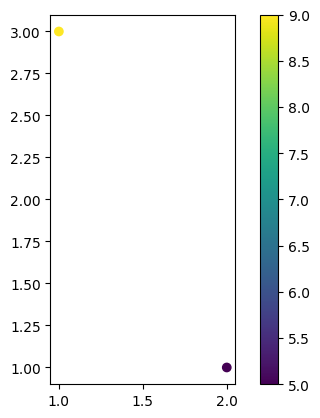

In [21]:
df_m = [ # Now make a mirrored df
    {'id':5,'point':Point(2,1)}, # Just swapping indices here
    {'id':9,'point':Point(1,3)} # and here
]
gdf_m = gpd.GeoDataFrame(df_m, # Now make it into a GeoDataFrame as before
                      geometry='point', 
                      crs = 'EPSG:4326') 
gdf_m.plot(column='id',legend=True)

## Coordinate System Transformations

On Tuesday, we learned that because coordinate systems assign unique coordinates to all locations in a space, we can safely go back and forth between different coordinate systems as long as they describe the same space. Let's see this in action.

First, we need to learn how to implement a coordinate system transformation. Fortunately, the `to_crs` [method](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoDataFrame.to_crs.html#geopandas.GeoDataFrame.to_crs) of `geopandas.GeoDataFrame`s makes this incredibly simple. Let's take our `gdf` in WGS 84 and put it into [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) (EPSG:3857), another really common CRS (it's what Google Maps uses). Web Mercator also has the nice feature that distances are measured in meters, rather than degrees, so performing this kind of transformation is often really useful. 

Before we implement the transformation, let's save a copy of the original point values so we can compare the final result. Making a new column for a `pandas.DataFrame` or `geopandas.GeoDataFrame` is similar to adding a new entry to a dictionary. Here, the "key" is the column name and the "value" is the list of values for each row. In this case, we'll just access the "point" column and make a new column called "original_point" that contains those same values. One detail of this is that sometimes when things are shared, like how the "point" and "original_point" columns will be the same, pandas and geopandas save memory by assuming they will always be the same, which can cause issues sometimes. To get around this, we'll add `.copy()` to the end to tell it explicity that they won't be the same forever.

In [22]:
gdf['original_point'] = gdf['point'].copy()
gdf

,id,point,original_point
0,5,POINT (1 2),POINT (1 2)
1,9,POINT (3 1),POINT (3 1)


Now let's implement the transform

In [23]:
gdf = gdf.to_crs("EPSG:3857")
gdf

,id,point,original_point
0,5,POINT (111319.491 222684.209),POINT (1 2)
1,9,POINT (333958.472 111325.143),POINT (3 1)


Simple as that! You can see that the "point" column now has very different numbers than before, but if we plot it it should look pretty much the same (though the proportions may have changed slightly)

<Axes: >

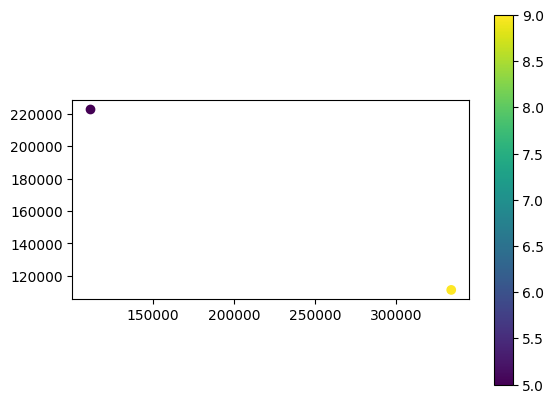

In [24]:
gdf.plot(column='id',legend=True)

Note that the transformation was only applied to "point" and not "original_point". That's because `gdf` only "knows" that "point" is its geometry column. To `gdf`, "original_point" is just another column with no special meaning, like how "point" was to `df`.

We can now transform `gdf` back to WGS 84 and see that we will get the original points.

In [25]:
gdf = gdf.to_crs("EPSG:4326")
gdf

,id,point,original_point
0,5,POINT (1 2),POINT (1 2)
1,9,POINT (3 1),POINT (3 1)


Note that this was not "undo"ing the first transformation: we first transformed from WGS 84 to Web Mercator, then from Web Mercator to WGS 84. The fact that we got back to where we started is precisely because coordinate systems assign unique coordinates to all locations. There are certain cases where, because of the finite precision of the way numbers are represented in computers, you can end up in a slightly different place, but this "error" will almost always be extremely small.